### Introduction

AutoRenew is a dataset containing detailed information about various features of used cars for sale. The goal is to develop a predictive model to estimate the price of used vehicles.

In this notebook, we will conduct an exploratory data analysis (EDA) and handle any null or meaningless values we encounter.

In [ ]:
# Data processing  
# -----------------------------------------------------------------------  
import numpy as np  
import pandas as pd  

# Other objectives  
# -----------------------------------------------------------------------  
import math  

# Graphics  
# -----------------------------------------------------------------------  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore") 

# Curstom functions 
# ----------------------------------------------------------------------- 
from src.support_eda import plot_categoric_distribution, plot_correlation_matrix, plot_numeric_distribution, plot_relation_tv_numeric, plot_outliers  

### Data loading

In [2]:
df = pd.read_csv('../data/raw/autorenew.csv')

In [3]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,test,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,test,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,test,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,test,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,test,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Dataset columns:**

- **dateCrawled**: Date and time when the car data was collected.

- **name**: Ad name, usually includes the car's make and model.

- **seller**: Type of seller (private or dealer).

- **offerType**: Type of offer (sale or auction).

- **price**: Car price in the local currency (likely euro or dollar).

- **abtest**: Field used for A/B testing, indicating different versions of the website or ad.

- **vehicleType**: Type of vehicle (sedan, SUV, hatchback, etc.).

- **yearOfRegistration**: Year the car was registered.

- **gearbox**: Type of transmission (manual or automatic).

- **powerCV**: Car's power in horsepower (HP).

- **model**: Specific car model.

- **kilometer**: Total mileage of the car.

- **monthOfRegistration**: Month the car was registered.

- **fuelType**: Type of fuel (gasoline, diesel, electric, etc.).

- **brand**: Car make.

- **notRepairedDamage**: Indicates if the car has unrepaired damage.

- **dateCreated**: Date the ad was created.

- **nrOfPictures**: Number of photos in the ad.

- **postalCode**: Postal code of the car's location.

- **lastSeen**: Last date and time the ad was viewed.

---

## Dates

First, we convert the dates to the `datetime` format to work with them.

In [4]:
df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['lastSeen'] = pd.to_datetime(df['lastSeen'])

Let's check the unique values of the years to see the time range we are dealing with.

In [5]:
dates = ['dateCrawled', 'dateCreated', 'lastSeen']

for date in dates:
    print(f"Unique year values for {date}: {df[date].dt.year.unique().tolist()}")

Unique year values for dateCrawled: [2016]
Unique year values for dateCreated: [2016, 2015, 2014]
Unique year values for lastSeen: [2016]


We see that the data was extracted exclusively in 2016, while the ads are only from 2014 to 2016. Therefore, we will simply assume that the newest vehicles can only be from 2016, instead of the current year. Beyond that, these columns do not provide additional value, so we will remove them.

In [6]:
df.drop(columns=['dateCrawled', 'dateCreated', 'lastSeen'], inplace=True)

---

## Check duplicated

We check for duplicates now that we have removed the dates, as it is possible that the same vehicle was registered multiple times with different dates.

In [7]:
df.duplicated().sum()

4380

There were indeed duplicates, so we will remove them.

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

---

## Numerical data

In [10]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,367148.0,17427.03,3609291.84,0.0,1150.0,2950.0,7150.0,2.147484e+09
yearOfRegistration,367148.0,2004.58,93.42,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerCV,367148.0,113.89,190.47,0.0,69.0,104.0,148.0,1.972600e+04
kilometer,367148.0,125700.64,40075.02,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,367148.0,5.73,3.71,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,367148.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,367148.0,50919.29,25771.17,1067.0,30629.0,49661.0,71638.0,9.999800e+04


**Quick Insights:**

- **`price`**: The minimum price is 0, which is odd since a free car doesn’t make sense. Additionally, the mean is much higher than the median, which could indicate numerous outliers, possibly luxury vehicles. However, the maximum price reaches an order of magnitude of 1e9 (a billion), which is clearly impossible and likely due to errors.

- **`yearOfRegistration`**: The minimum value is 1000, which is illogical as cars didn’t exist before 1900 (and vehicles that old are rarely sold). Additionally, there are values like 9999, which are likely errors in data entry.

- **`powerCV`**: A minimum of 0 is unlikely, and a maximum of 19,700 HP is unrealistic, given that even the most powerful race cars rarely exceed 1,000 HP. The rest of the values seem reasonable, with most falling within the typical range of 50 to 150 HP.

- **`kilometer`**: These values seem reasonable. Additionally, the mean and median are similar, suggesting a more uniform distribution.

- **`monthOfRegistration`**: This variable is truly categorical. The minimum value, 0, is impossible, but values between 1 and 12 are logical and consistent.

- **`nrOfPictures`**: All entries have a value of 0. We drop it.

- **`PostalCode`**: This variable corresponds to postal codes and could be treated as categorical. However, there is no information about the country they belong to or a way to determine it, which limits its usefulness for analysis. From the name of some entries, we suspect it might be Germany, but there’s no way to confirm it. For this reason, we will decide to remove it.

In [11]:
# Drops
df.drop(columns=['postalCode', 'nrOfPictures'], inplace=True)

---

### `price`

In [12]:
df['price'].isna().value_counts()

price
False    367148
Name: count, dtype: int64

Since the variable we want to predict (target variable) is the price, we must ensure there are no null values, and if any exist, we will remove them.

We observe that there are no null values, but we will directly filter for prices that make sense.

Extremely low vehicle prices do not make sense. However, it is difficult to establish a strict criterion for filtering, as very old vehicles or those with damage may genuinely have low prices.

In [13]:
round(df[df['price'] < 100].shape[0] / df.shape[0] * 100, 2)

3.57

Data with a price lower than 100 is very likely to be erroneous and represents around 3.6% of the dataset, so it seems reasonable to remove them.  
It is possible that there are vehicles that genuinely have a price below 100 due to unrepaired damage or age, but it is difficult to establish this criterion, so we will proceed in this manner.

After reviewing the data, we can conclude that all prices above 4 million correspond to erroneous entries.

In [14]:
print(f"We have a total of {df[df['price'] > 4e6].shape[0]} entries with a price greater than 4 M")

df[df['price'] > 4e6].head()

We have a total of 52 entries with a price greater than 4 M


,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
14663,Tausch_moeglich_Polo_vw_n9,private,offer,11111111,control,coupe,2003,manually,63.0,polo,150000,2,petrol,volkswagen,NaN
20746,Golf3_Schlachtfest,private,offer,12345678,test,NaN,1995,NaN,0.0,NaN,150000,0,NaN,volkswagen,NaN
21467,Porsche_911_911R_1_of_20_ORIGINAL_R_nur_798KG!...,private,offer,9999999,control,coupe,1967,manually,212.0,911,50000,10,petrol,porsche,no
39625,Tausche_volvo_v40_gegen_van,private,offer,12345678,control,NaN,2018,manually,94.0,v40,150000,6,NaN,volvo,no
54295,Mazda_5_2.0_CD_DPF_Exclusive,private,offer,10000000,control,bus,2007,manually,141.0,5_reihe,150000,2,diesel,mazda,no


Therefore, we filter the data by prices in this way.

In [15]:
filter_price = (df['price'] > 100) & (df['price'] < 4e6)

df = df[filter_price]

---

### `yearOfRegistration`

The registration year cannot be later than 2016, which is the latest year of data extraction. However, let's check the entries for subsequent years as well.

In [16]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts().head()

yearOfRegistration
2017    9855
2018    3766
2019      15
9999      14
5000      14
Name: count, dtype: int64

We see that we have quite a few entries in 2017 and 2018, so we will keep them, as it might be realistic that data extraction took place in those years. The remaining values are less frequent, so we can assume they are errors and label them as null.

Let's see what happens with vehicles with older registration years. For example, let's check how many vehicles are older than 1930.

In [17]:
df[df['yearOfRegistration'] < 1930]['yearOfRegistration'].value_counts().head()

yearOfRegistration
1910    35
1000    23
1929     7
1800     3
1234     3
Name: count, dtype: int64

There are 36 entries from 1910 that likely represent errors. Let's visualize the distribution graphically.

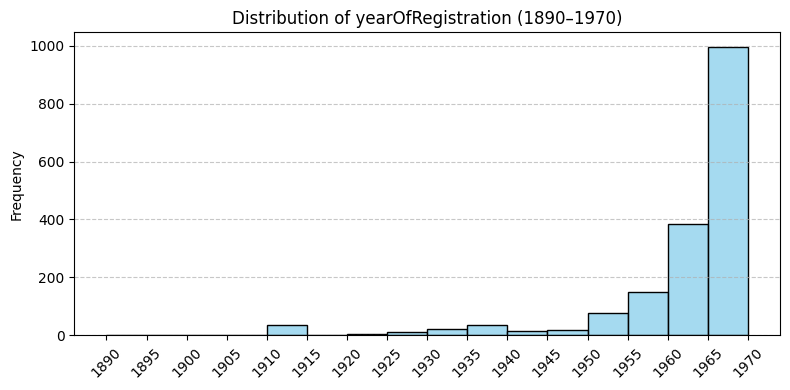

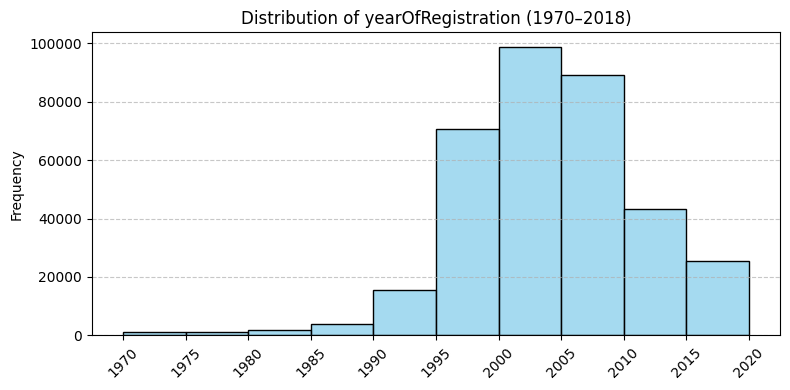

In [18]:
plot_numeric_distribution(df, 1890, 1970, 'yearOfRegistration', n=5, size=(8,4))
plot_numeric_distribution(df, 1970, 2018, 'yearOfRegistration', n=5, size=(8,4))

That group from 1910 clearly stands out, so we will treat entries prior to 1920 as null.

We apply the filters by converting the year values to null.

In [19]:
df['yearOfRegistration'] = df['yearOfRegistration'].apply(lambda x: np.nan if (x < 1920 or x > 2018) else x)

---

### `powerCV`

A vehicle with more than 1200 HP practically doesn't exist, so let's examine what happens with high power values up to this threshold. We'll consider the range from 500 to 1200. Values above 1200 will be directly converted to null.

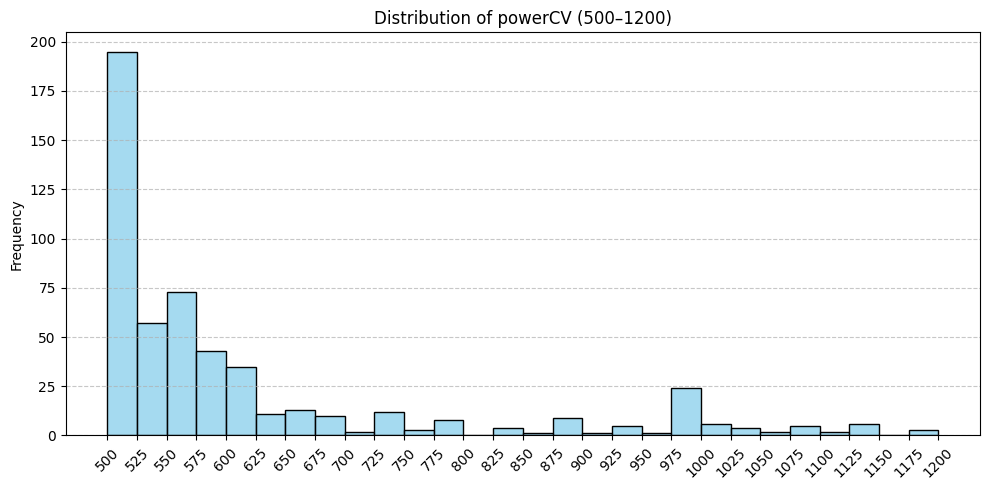

In [20]:
plot_numeric_distribution(df, 500, 1200, 'powerCV', n = 25)

In [21]:
df[(df['powerCV'] > 500) & (df['powerCV'] < 1200)].sample(5)

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
323873,Mercedes_Benz_CL_500,private,offer,16500,control,coupe,2000.0,automatic,501.0,cl,50000,3,petrol,mercedes_benz,yes
160001,Chevrolet_Matiz_BJ_2005__ohne_TÜV_,private,offer,500,test,small car,2005.0,manually,576.0,matiz,125000,0,petrol,chevrolet,NaN
91730,Mercedes_V58K_Vaeth_AMG,private,offer,39500,control,NaN,2005.0,automatic,620.0,c_klasse,100000,3,petrol,mercedes_benz,no
95109,Lamborghini_Gallardo_LP_550_2,private,offer,135500,test,convertible,2013.0,NaN,543.0,NaN,20000,7,petrol,sonstige_autos,no
258560,Citroën_C2_VTR,private,offer,2400,control,small car,2004.0,manually,733.0,c2,125000,0,NaN,citroen,NaN


We observe that from 500 onward, the frequency of vehicles decreases significantly. However, it is difficult to establish an appropriate criterion to discern whether the values make sense, as some are clearly erroneous while others correspond to genuinely powerful vehicles. We'll set the cutoff at 1200.

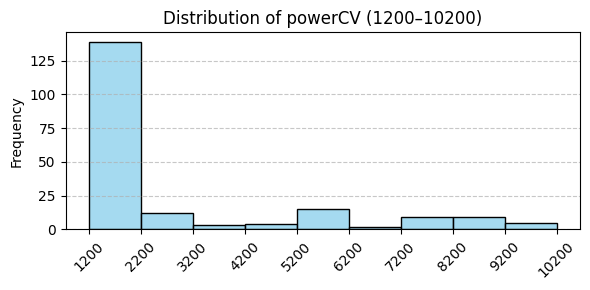

In [22]:
plot_numeric_distribution(df, 1200, 10200, 'powerCV', n = 1000, size=(6, 3))

We see that above 1200, there are very few entries compared to the total dataset, so we convert them to null without issue.

Regarding the lower range, vehicles with lower power that make sense can go down to 50 HP. Let's set the threshold at 40 HP to allow for the possibility of classic or very old vehicles that may have less power.

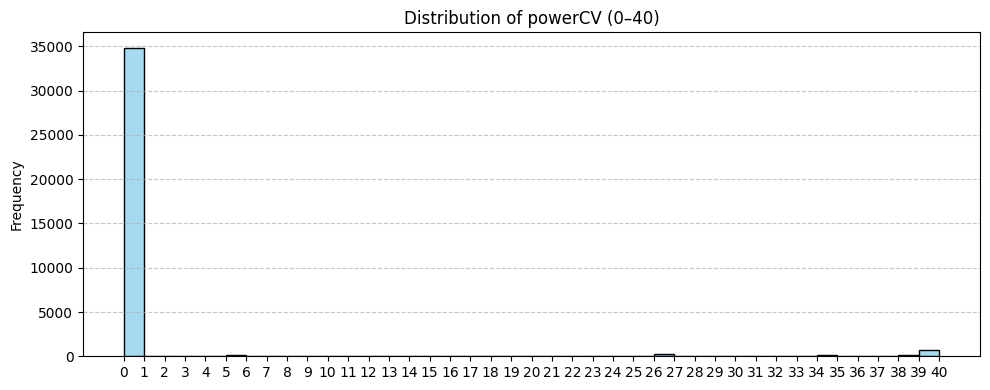

In [23]:
plot_numeric_distribution(df, 0, 40, 'powerCV', n = 1, size=(10,4), rotation=0)

We see that the vast majority of values are 0. Obviously, these entries are incorrect, so we will nullify them. Likewise, we can review what happens within this range of power values.

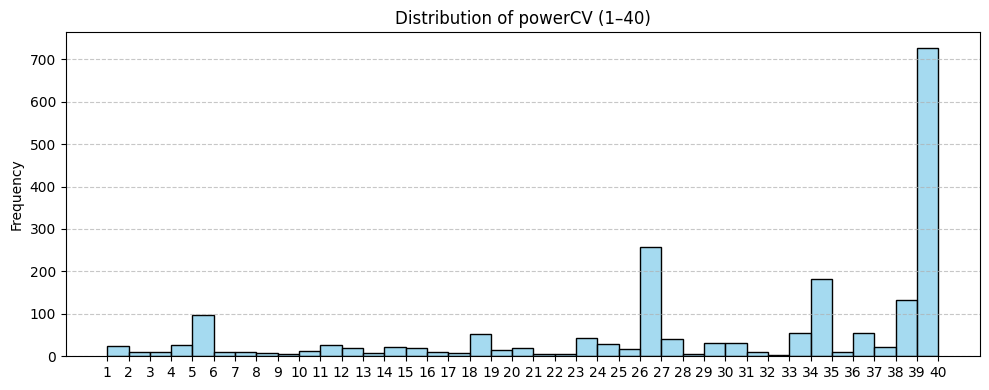

In [24]:
plot_numeric_distribution(df, 1, 40, 'powerCV', n = 1, size=(10,4), rotation=0)

Indeed, we confirm that from 40 HP onwards, there is a significant number of values.

In [25]:
df[(df['powerCV'] < 40) & (df['powerCV'] > 0)].sample(5)

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
166325,Trabant_601,private,offer,5999,test,convertible,1977.0,manually,26.0,601,60000,7,petrol,trabant,no
257171,##_Seat_Marbella_ohne_Papiere_25KM/H_Mofa_Auto...,private,offer,550,test,small car,1998.0,manually,34.0,andere,80000,6,petrol,seat,no
128266,Trabant_601_1964_Survivor_Oldtimer,private,offer,3999,test,NaN,1964.0,manually,23.0,601,50000,11,petrol,trabant,NaN
310533,Bmw_1er_118i_4/5_tuerer,private,offer,5900,test,NaN,2017.0,manually,1.0,1er,125000,5,petrol,bmw,no
242302,Aixam__mega_400__Leicht_KFZ__45_km/h__ab_16__M...,private,offer,1500,test,other,1998.0,automatic,5.0,NaN,40000,5,diesel,sonstige_autos,no


We also confirm that most of these entries do not seem to make sense, so we will treat them as null.

In [26]:
df['powerCV'] = df['powerCV'].apply(lambda x: np.nan if (x < 40 or x > 1200) else x)

---

###  `kilometer`

The `kilometer` variable should be continuous numerical. However, the data seems to be grouped into discrete mileage intervals, such as multiples of 5000 or 10000 kilometers. This makes sense, as it is common in used car ads to categorize mileage in rounded values.

Grouping the data this way introduces a bias and can distort the perception of the actual mileage of the cars. Unfortunately, we do not have access to more detailed information, so we will proceed with this as is.

In [27]:
df['kilometer'].value_counts()

kilometer
150000    228495
125000     36721
100000     15094
90000      12095
80000      10696
70000       9544
60000       8381
50000       7418
40000       6178
30000       5776
20000       5398
5000        5369
10000       1814
Name: count, dtype: int64

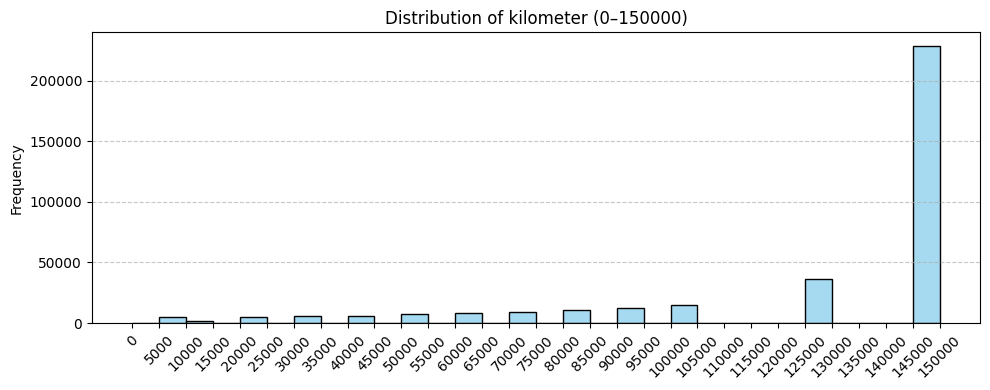

In [28]:
plot_numeric_distribution(df, 0, 150000, 'kilometer', n = 5000, size = (10, 4))

Since all these values are reasonable, we will not add any additional filters.

---

### `monthOfRegistration`

In [29]:
df['monthOfRegistration'].value_counts()

monthOfRegistration
3     35007
6     31914
0     31201
4     29870
5     29514
7     27956
10    26421
11    24612
12    24336
9     24163
1     23529
8     22859
2     21597
Name: count, dtype: int64

We have values from 0 to 12. These correspond to the vehicle's registration month, except for 0, which we can interpret as unknown.

This variable is essentially categorical, so we will convert it to an object.

In [30]:
df['monthOfRegistration'] = df['monthOfRegistration'].astype(object)

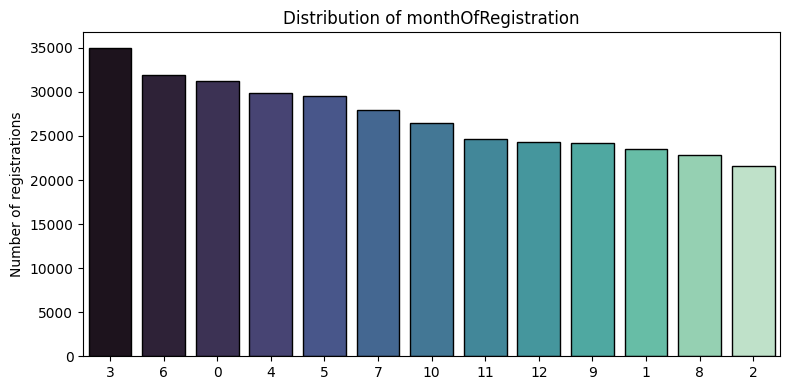

In [31]:
plot_categoric_distribution(df, 'monthOfRegistration', rotation=0)

It seems that some months are more frequent than others, although the differences are not significant. Since the main information about the temporal evolution of the vehicle's registration is captured in `yearOfRegistration`, we can ignore this category for now.

In [32]:
df.drop(columns='monthOfRegistration', inplace=True)

---

## Categorical data

In [33]:
df.describe(include='O').T

,count,unique,top,freq
name,352979,222118,BMW_318i,624
seller,352979,2,private,352977
offerType,352979,2,offer,352973
abtest,352979,2,test,182845
vehicleType,228375,7,small car,76392
gearbox,336758,2,manually,262574
model,335413,251,golf,28534
fuelType,324641,7,petrol,214353
brand,352979,40,volkswagen,75426
notRepairedDamage,288969,2,no,255922


---

### `name`

We have many different entries for `name`, so it doesn't really provide much useful information for building a predictive price model. Information such as the model and brand is stored in other variables.

In [34]:
df.drop(columns='name', inplace=True)

---

### `seller`

In [35]:
df['seller'].value_counts()

seller
private       352977
commercial         2
Name: count, dtype: int64

There are two types of `seller`: `private` and `commercial`. However, out of more than 350,000 entries, only 2 are `commercial`, so this column does not provide useful information. We will remove it as well.

In [36]:
df.drop(columns='seller', inplace=True)

---

### `offerType`

In [37]:
df['offerType'].value_counts()

offerType
offer      352973
request         6
Name: count, dtype: int64

There are two types of `offerType`: `offer` and `request`. However, out of more than 350,000 entries, only 6 are `request`, so this column does not provide useful information. We will remove it as well.

In [38]:
df.drop(columns='offerType', inplace=True)

---

### `abtest`

Initially, this field is used for an A/B test, but we are not entirely sure of its real purpose. We might be able to remove it, but first, let's check some key metrics.

In [39]:
df.groupby('abtest')['price'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
abtest,,,,,,,,
control,170134.0,6083.27,16864.48,101.0,1299.0,3100.0,7499.0,2995000.0
test,182845.0,6160.32,19649.56,101.0,1299.0,3100.0,7499.0,3895000.0


The group sizes are very similar, and the median price for each group is identical, as are the quartiles. The mean and standard deviation are affected by outliers, so the differences are not particularly significant.

We conclude that we can also dispense with this column.

In [40]:
df.drop(columns='abtest', inplace=True)

---

### `vehicleType`

In [41]:
df['vehicleType'].unique()

array([nan, 'coupe', 'suv', 'small car', 'convertible', 'bus', 'combi',
       'other'], dtype=object)

We start converting `nan` to `unknown`

In [42]:
df['vehicleType'].fillna('unkonwn', inplace=True)

In [43]:
df['vehicleType'].value_counts()

vehicleType
unkonwn        124604
small car       76392
combi           64925
bus             29298
convertible     22324
coupe           18233
suv             14117
other            3086
Name: count, dtype: int64

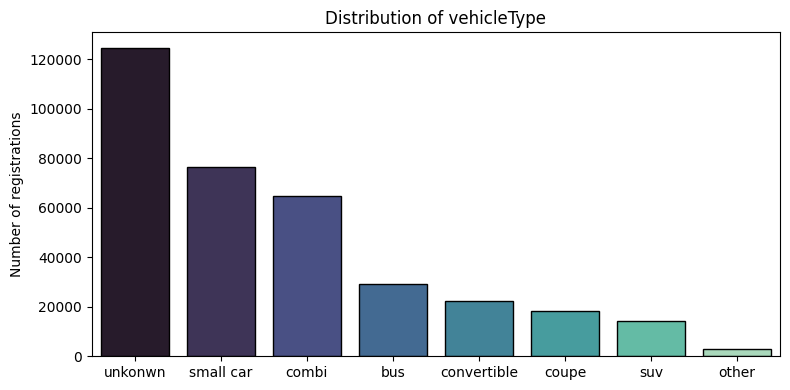

In [44]:
plot_categoric_distribution(df, 'vehicleType', rotation=0)

Quick insights:

* `small car` are compact and practical, dominating the market due to their affordability and suitability for city driving. 

* `combis` are versatile family vehicles, popular for their space and functionality. 

* `bus` serve collective transportation needs with moderate demand. However, after inspecting some individual data, it only appears to be vans rather than buses.

* `convertible` and `coupe` cater to style and leisure enthusiasts, while `suv` appeal to those needing space and off-road capability. 

* `other` vehicles may represent niche or specialized types with limited presence. 

* `unkonwn` vehicles represent vehicles with no category information. 

Overall, practicality and versatility drive the majority of demand.

---

### `gearbox`

In [45]:
df['gearbox'].unique()

array(['manually', 'automatic', nan], dtype=object)

We start converting `nan` to `unknown`

In [46]:
df['gearbox'].fillna('unkonwn', inplace=True)

In [47]:
df['gearbox'].value_counts()

gearbox
manually     262574
automatic     74184
unkonwn       16221
Name: count, dtype: int64

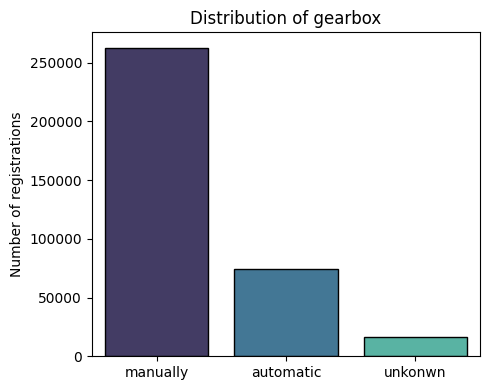

In [48]:
plot_categoric_distribution(df, 'gearbox', size=(5, 4), rotation=0)

Vehicles with manual transmission dominate over automatic ones, revealing that it is the most popular option in the market, especially for used vehicles.

---

### `model`

In [49]:
df['model'].nunique()

251

In [50]:
df['model'].value_counts()

model
golf               28534
andere             25222
3er                19704
polo               12343
corsa              11820
                   ...  
serie_2                8
rangerover             6
serie_3                3
serie_1                1
discovery_sport        1
Name: count, Length: 251, dtype: int64

With `model`, we face a similar situation as with `name`. We have 251 different models, but this information is essentially a subcategory of `brand`, so we will remove this column and keep `brand`.

In [51]:
df.drop(columns='model', inplace=True)

---

### `fuelType`

In [52]:
df['fuelType'].unique()

array(['petrol', 'diesel', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electro'], dtype=object)

We start converting `nan` to `unknown`

In [53]:
df['fuelType'].fillna('unkonwn', inplace=True)

In [54]:
df['fuelType'].value_counts()

fuelType
petrol     214353
diesel     104044
unkonwn     28338
lpg          5172
cng           549
hybrid        268
other         156
electro        99
Name: count, dtype: int64

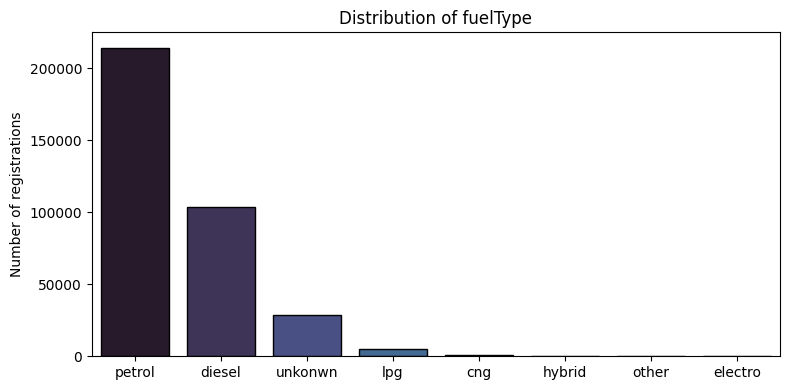

In [55]:
plot_categoric_distribution(df, 'fuelType', rotation=0)

`petrol` and `diesel` are the most popular options. This makes sense, especially in the used car market, as `hybrid` or `electro` technologies are newer and have been on the market for a shorter time.

---

### `brand`

In [56]:
df['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [57]:
df['brand'].nunique()

40

There are 40 different brands. however, in German, "sonstige Autos" translates to "other cars" in English. This reinforces the possibility that the vehicles could be from Germany

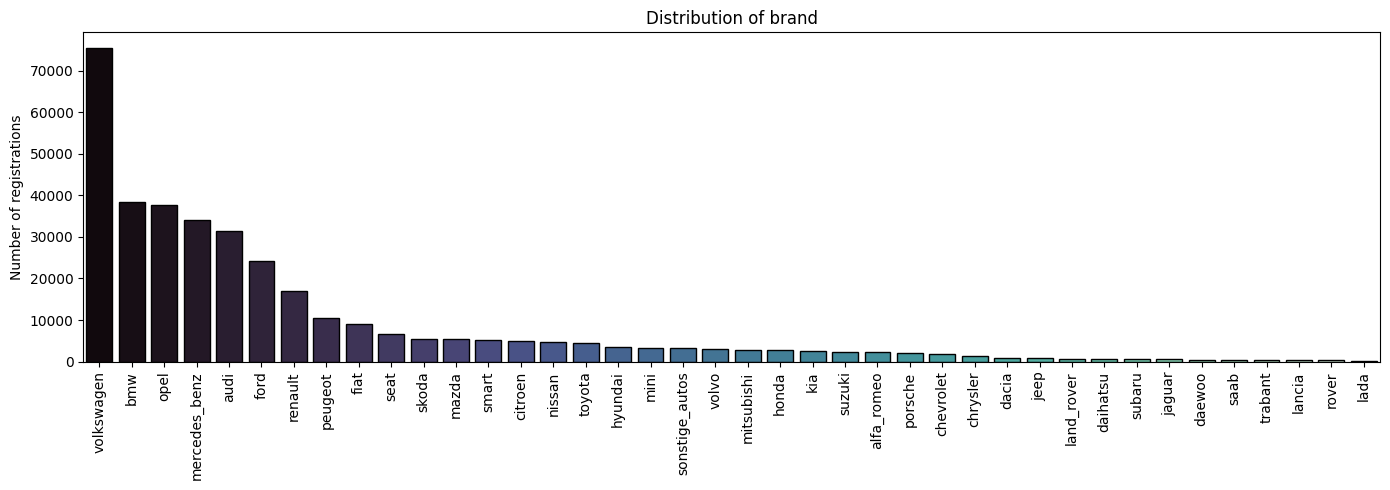

In [58]:
plot_categoric_distribution(df, 'brand', size=(14, 5), rotation=90)

`Volkswagen` clearly dominates the market. Well-known brands such as `BMW`, `Opel`, `Mercedes`, `Audi`, `Ford`, etc., follow with a more balanced distribution.

---

### `notRepairedDamage`

In [59]:
df['notRepairedDamage'].unique()

array([nan, 'yes', 'no'], dtype=object)

We start converting `nan` to `unknown`

In [60]:
df['notRepairedDamage'].fillna('unkonwn', inplace=True)

In [61]:
df['notRepairedDamage'].value_counts()

notRepairedDamage
no         255922
unkonwn     64010
yes         33047
Name: count, dtype: int64

In [62]:
df['notRepairedDamage'].value_counts(normalize=True)

notRepairedDamage
no         0.725035
unkonwn    0.181342
yes        0.093623
Name: proportion, dtype: float64

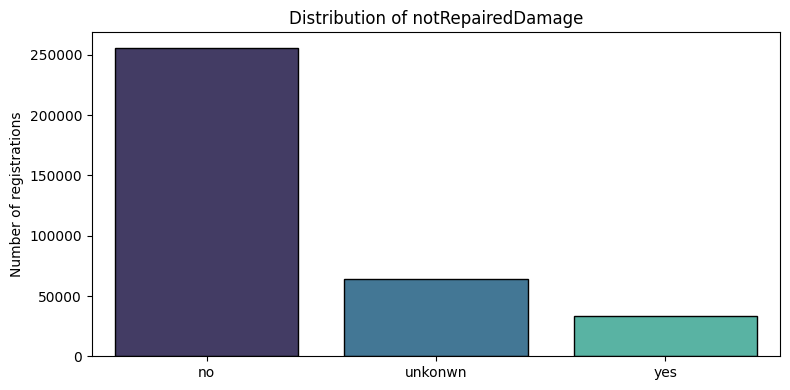

In [63]:
plot_categoric_distribution(df, 'notRepairedDamage', rotation=0)

The majority of cars (~72.5%) have no damage, with some unknown entries and a bit less than 10% of damaged cars.

---

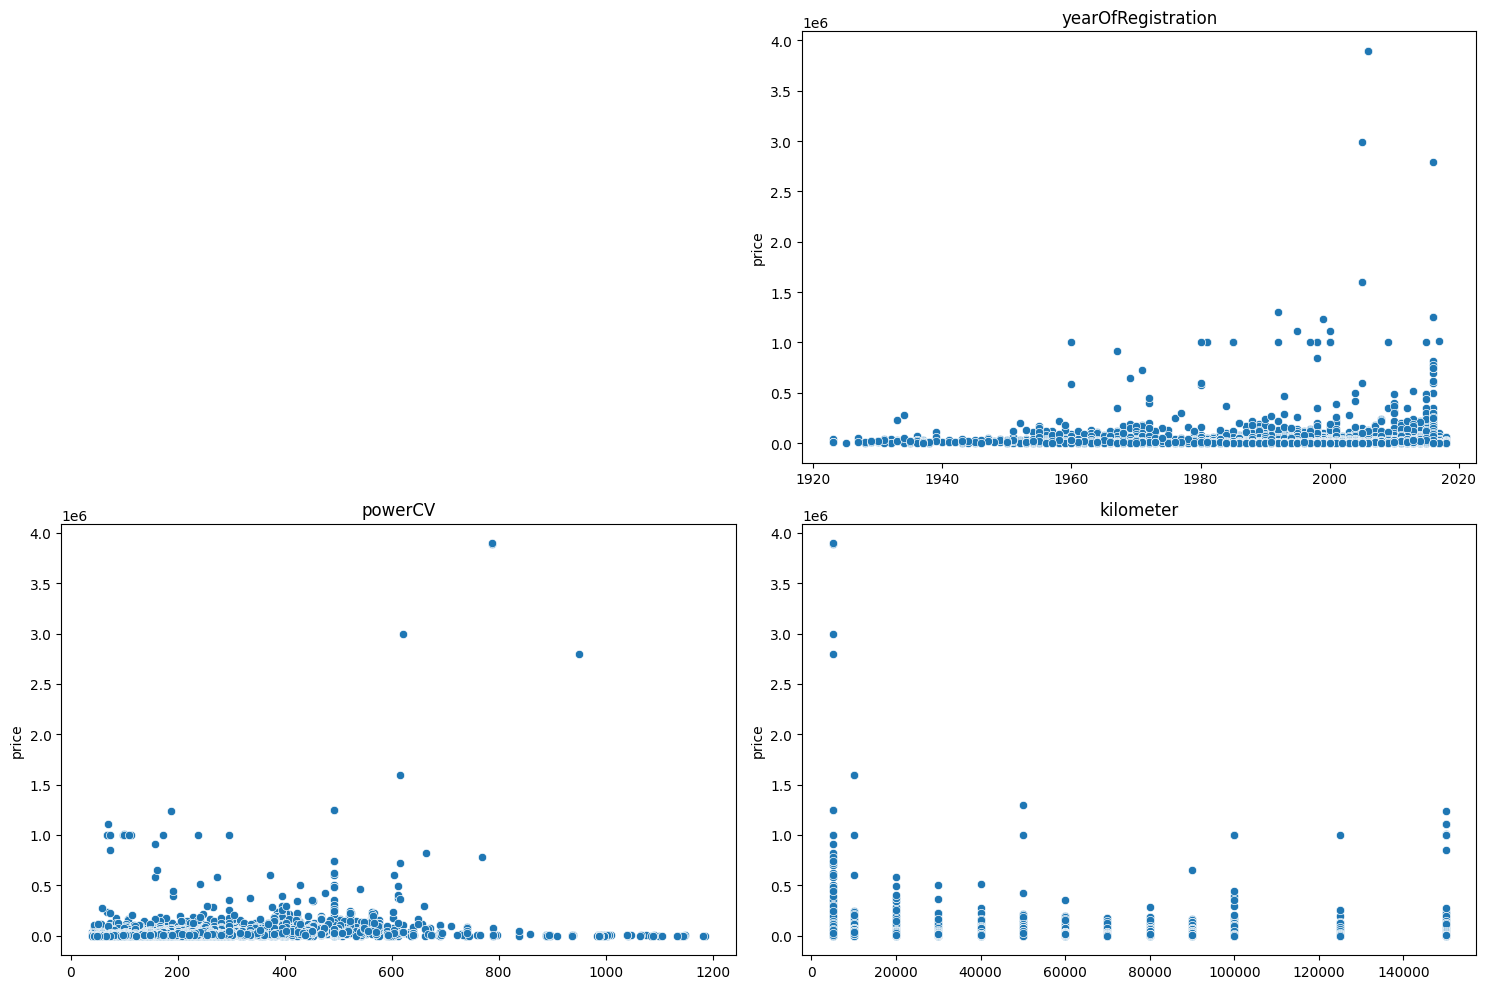

In [64]:
plot_relation_tv_numeric(df, 'price')

Apparently, we do not see any clear correlation. Let's examine the correlation coefficients.

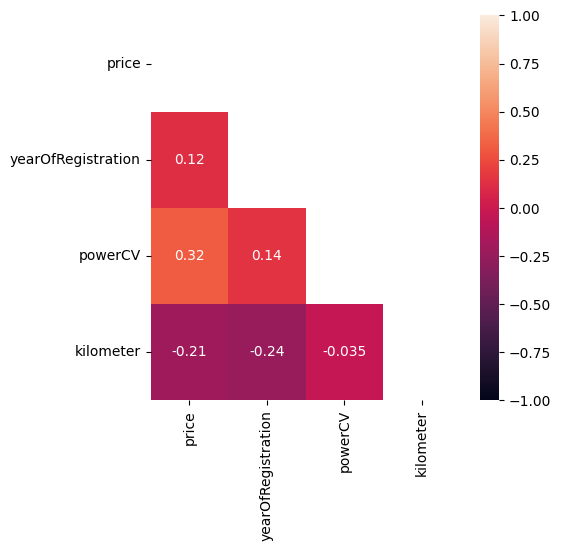

In [65]:
plot_correlation_matrix(df)

We observe a relatively moderate positive correlation between `powerCV` and `price`, which makes sense as more powerful vehicles tend to be more expensive, though other factors also play a role.

There is a weak negative correlation between `kilometer` and `price`, which is also logical since vehicles with higher mileage tend to have lower prices.

Finally, there is a weak negative correlation between `yearOfRegistration` and `kilometer`, indicating that older vehicles (with lower registration years) tend to have higher mileage, which is consistent.

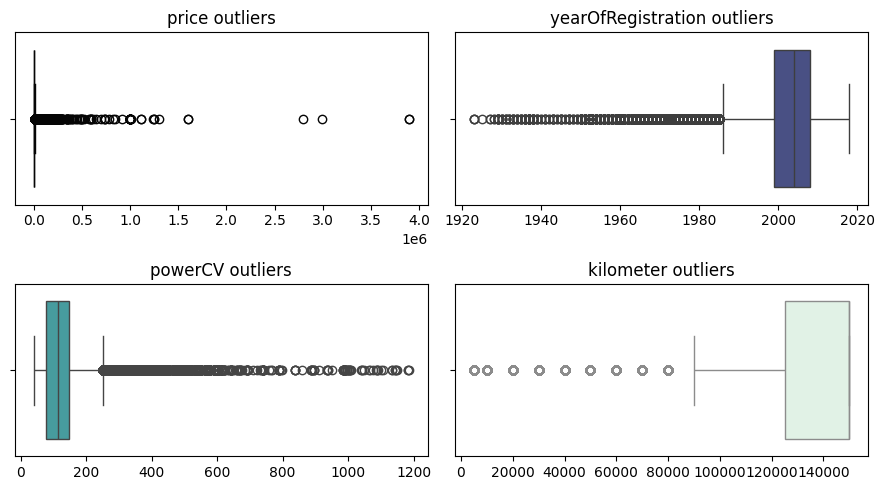

In [66]:
plot_outliers(df)

- **`price`**: Clear outliers that could correspond to luxury supercars identified earlier.  

- **`powerCV`**: Outliers are relatively evenly distributed. The distribution was better observed in the previous histograms.

- **`yearOfRegistration`**: Outliers in the oldest dates, more evenly distributed.  

- **`kilometer`**: The grouping into discrete values is noticeable.  

---

**Note**: If we examine the duplicates, we now see a large number of them. However, we will NOT remove them, as they could represent different cars with the same characteristics. Truly duplicate entries were already handled at the beginning.

In [67]:
df.duplicated().sum()

46657

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352979 entries, 0 to 371527
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               352979 non-null  int64  
 1   vehicleType         352979 non-null  object 
 2   yearOfRegistration  352807 non-null  float64
 3   gearbox             352979 non-null  object 
 4   powerCV             316255 non-null  float64
 5   kilometer           352979 non-null  int64  
 6   fuelType            352979 non-null  object 
 7   brand               352979 non-null  object 
 8   notRepairedDamage   352979 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 26.9+ MB


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352979 entries, 0 to 371527
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               352979 non-null  int64  
 1   vehicleType         352979 non-null  object 
 2   yearOfRegistration  352807 non-null  float64
 3   gearbox             352979 non-null  object 
 4   powerCV             316255 non-null  float64
 5   kilometer           352979 non-null  int64  
 6   fuelType            352979 non-null  object 
 7   brand               352979 non-null  object 
 8   notRepairedDamage   352979 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 26.9+ MB


We save the dataframe as a CSV file.

In [70]:
df.to_csv('../data/output/autorenew_eda.csv')